In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

import re

from sklearn.preprocessing import LabelEncoder
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# # from catboost import CatBoostClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
# from xgboost import XGBRFClassifier

# from sklearn.model_selection import train_test_split

# from sklearn.metrics import accuracy_score,recall_score
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score


In [3]:
history_df = pd.DataFrame()
file_path = 'history.csv'
if os.path.isfile(file_path) and os.path.getsize(file_path) > 0:
    history_df = pd.read_csv(file_path)
else:
    print("Error: The file is empty or does not exist.")

/var/folders/xp/pns_c2r97xn7m5lw5_1_d9q00000gn/T/ipykernel_71551/4118017018.py:4: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  history_df = pd.read_csv(file_path)


In [4]:
'''
@param df: A pandas DataFrame
@param cols: List of columns existing in df
@return: df with cols dropped
'''
def drop_cols(df, cols):
    df = df.drop(cols, axis=1)
    return df

In [5]:
'''
@param df: A pandas DataFrame
@param cols: List of boolean columns in df
@return: df with the values in cols mapped to 0 (for False or blank) or 1 (for True)
'''
def boolean_map(df, cols):
    for col in cols:
        df[col] = df[col].fillna('f').map({'t': 1, 'f': 0})
    return df

In [6]:
'''
@param df: A pandas DataFrame
@param cols: List of datetime columns in df
@return: df with the values in cols standardized to a number between 0 and 1.
'''
def parse_time(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col])
        min_date = df[col].min()
        df[col] = df[col].fillna(min_date)

        df[col] = df[col].astype(int)
        min = df[col].min()
        max = df[col].max()
        df[col] = (df[col] - min) / (max - min)

    return df

In [7]:
'''
@param df: A pandas DataFrame
@param cols: List of object columns in df
@return: df with the values in cols mapped to arbitrary numbers
'''
def encode_labels(df, cols):
    label_encoder = LabelEncoder()
    for col in cols:
        df[col] = label_encoder.fit_transform(df[col])

    return df


In [8]:
'''
@param df: A pandas DataFrame
@param cols: List of object columns in df
@return: df with the values in cols mapped to arbitrary numbers
'''
def encode_labels(df, cols):
    label_encoder = LabelEncoder()
    for col in cols:
       
        df[col] = df[col].fillna('missing')

        valid_data = df[col][df[col] != 'missing']
        label_encoder.fit(valid_data)

        df.loc[df[col] != 'missing', col] = label_encoder.transform(df[df[col] != 'missing'][col])

        df[col] = df[col].replace('missing', -999).astype(int)

    return df

### 1.0 Drop unused columns

We do not want our model to be trained on data from any of these columns. The code looks a bit messy because we did this step in different ways.

In [9]:
df_nathan = history_df[['id', 'type_code', 'class_id', 'inception_date', 'branch', 'include_client_consolidation', 'use_client_address', 'credit_limit_type', 'is_arp_locked', 'dividend_confirm_code']]

df_cloris = history_df[['options_trading_type', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'share_name_address_to_issuer', 'shareholder_instructions_received', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_spousal_transfer', 'terminal_code', 'deceased_fair_market_value', 'discretionary_trading_authorized']]

df_cherry = history_df.iloc[:, 52:79]
df_cherry = drop_cols(df_cherry, ['esir_number', 'dup_trip_quad_code', 'function_code', 'portfolio_cost_method','shareholder_language', 'interactive_portfolio_code', 'title', 'non_plan_book_value_flag', 'conjunction', 'portfolio_name_address_option', 'portfolio_summary_option'])

df_matthew = history_df.iloc[:, -27:]
df_matthew = drop_cols(df_matthew, ['is_broker_account', 'is_gl_account', 'is_control_account', 'is_plan_grandfathered'])

training_df = pd.concat([df_nathan, df_cloris, df_cherry, df_matthew], axis=1)
training_df.head(3)

,id,type_code,class_id,inception_date,branch,include_client_consolidation,use_client_address,credit_limit_type,is_arp_locked,dividend_confirm_code,...,is_family_resp,is_hrdc_resp,resp_specimen_plan,inserted_at,updated_at,is_olob,retail_last_maintenance_time,retail_last_maintenance_user,visible_in_reports,label
0,893724,CASH SWEEP,3.0,2017-08-18,IAVM,t,f,0.0,NaN,0.0,...,NaN,NaN,NaN,2023-05-30 14:20:18.531115+00,2023-08-08 18:53:01.439561+00,f,NaN,NaN,f,Churn
1,1268094,RRIF,5.0,2018-11-08,IAVM,t,t,0.0,f,0.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2023-01-03 00:00:00,BATCH,t,Churn
2,606613,SPOUSAL RRSP,5.0,2009-04-08,IAVM,f,f,0.0,f,0.0,...,f,f,NaN,2023-05-30 14:20:18.531115+00,2023-08-10 21:47:25.370403+00,f,2018-07-17 00:00:00,GUERINO,f,Churn


### 1.1 Map Boolean Columns

In [10]:
bool_nathan = ['include_client_consolidation', 'use_client_address', 'is_arp_locked']
bool_cloris = ['share_name_address_to_issuer', 'shareholder_instructions_received', 'is_tms_eligible', 'is_agent_bbs_participant', 'is_spousal_transfer', 'discretionary_trading_authorized']
bool_cherry = ['receive_general_mailings', 'has_discrete_auth', 'is_non_objecting_beneficial_owner', 'is_objecting_to_disclose_info', 'consent_to_email_delivery', 'consent_to_pay_for_mail', 'has_received_instruction']
bool_matthew = ['is_inventory_account', 'is_extract_eligible', 'is_pledged', 'is_resp', 'is_family_resp', 'is_hrdc_resp'] + ['is_olob', 'visible_in_reports', 'use_original_date_for_payment_calc']

training_df = boolean_map(training_df, bool_nathan + bool_cloris + bool_cherry + bool_matthew)

### 1.2 Parse Datetime Columns

In [11]:
time_nathan = ['inception_date']
time_cherry = ['last_update_date']
time_matthew = ['last_maintenance_time', 'plan_effective_date', 'plan_end_date', 'rrif_original_date', 'inserted_at', 'updated_at', 'retail_last_maintenance_time']

training_df = parse_time(training_df, time_nathan + time_cherry + time_matthew)

### 1.3 Numerize Type Columns

In [12]:
#cherry further cleaning
training_df['special_tag'] = training_df['special_tag'].replace('NOT FOUND', np.nan)

def parse_risk_tolerance(rt_string):
    parts = re.findall(r'([L|M|Q|H])(\d{2})', rt_string)
    rt_dict = {'Low': 0, 'Medium': 0, 'Medium-High': 0, 'High': 0}
    for part in parts:
        if part[0] == 'L':
            rt_dict['Low'] = int(part[1])
        elif part[0] == 'M':
            rt_dict['Medium'] = int(part[1])
        elif part[0] == 'Q':
            rt_dict['Medium-High'] = int(part[1])
        elif part[0] == 'H':
            rt_dict['High'] = int(part[1])
    return rt_dict

def parse_investment_objective(io_string):
    parts = re.findall(r'([B|C|D|G|M|S|X])(\d{2})', io_string)
    io_dict = {'Income': 0, 'Growth': 0, 'Speculative': 0, 'Liquidity': 0, 'Safety': 0}
    for part in parts:
        if part[0] == 'B':
            io_dict['Income'] = int(part[1])
        elif part[0] == 'C' or part[0] == 'G':
            io_dict['Growth'] += int(part[1])
        elif part[0] == 'D' or part[0] == 'S':
            io_dict['Speculative'] += int(part[1])
        elif part[0] == 'M':
            io_dict['Liquidity'] = int(part[1])
        elif part[0] == 'X':
            io_dict['Safety'] = int(part[1])
    return io_dict

training_df['risk_tolerance'] = training_df['risk_tolerance'].astype(str).apply(parse_risk_tolerance)
training_df['investment_objective'] = training_df['investment_objective'].astype(str).apply(parse_investment_objective)

rt_columns = ['Low', 'Medium', 'Medium-High', 'High']
io_columns = ['Income', 'Growth', 'Speculative', 'Liquidity', 'Safety']

for col in rt_columns:
    training_df[col] = training_df['risk_tolerance'].apply(lambda x: x[col])

for col in io_columns:
    training_df[col] = training_df['investment_objective'].apply(lambda x: x[col])

training_df.drop(['risk_tolerance', 'investment_objective'], axis=1, inplace=True)
training_df.head()

,id,type_code,class_id,inception_date,branch,include_client_consolidation,use_client_address,credit_limit_type,is_arp_locked,dividend_confirm_code,...,label,Low,Medium,Medium-High,High,Income,Growth,Speculative,Liquidity,Safety
0,893724,CASH SWEEP,3.0,0.808752,IAVM,1,0,0.0,0,0.0,...,Churn,0,0,0,0,0,0,0,0,0
1,1268094,RRIF,5.0,0.847716,IAVM,1,1,0.0,0,0.0,...,Churn,0,90,0,10,5,85,10,0,0
2,606613,SPOUSAL RRSP,5.0,0.542538,IAVM,0,0,0.0,0,0.0,...,Churn,0,50,0,50,0,50,50,0,0
3,741930,CASH,3.0,0.916405,IAVM,1,1,0.0,0,0.0,...,Churn,0,99,0,0,0,99,0,0,0
4,1137922,CASH,3.0,0.806311,IAVM,1,0,0.0,0,0.0,...,Churn,0,99,0,0,0,99,0,0,0


In [13]:
type_nathan = ['type_code', 'branch']
type_cloris = ['terminal_code'] 
type_matthew = ['last_maintenance_user', 'retail_last_maintenance_user']
type_cherry = ['iso_funds_code', 'special_tag', 'tms_settlement_location', 'portfolio_report_option', 'loan_limit_override']

training_df = encode_labels(training_df, type_nathan + type_cloris + type_matthew + type_cherry)

### 1.4 Other

In [14]:
# Nathan
training_df.class_id.fillna(-999, inplace=True)
training_df.credit_limit_type.fillna(-999, inplace=True)
training_df.dividend_confirm_code.fillna(-999, inplace=True)

# Cloris
training_df.deceased_fair_market_value.fillna(0, inplace=True)
training_df.options_trading_type.fillna(-999, inplace=True)
training_df.interest_dividend_conversion_type.fillna(-999, inplace=True)
training_df.guarantee_gtor_type.fillna(-999, inplace=True)

# Matthew
training_df.number_of_beneficiaries.fillna(0, inplace=True)
training_df.label = training_df.label.map({'No Churn': 0, 'Churn': 1})

training_df

,id,type_code,class_id,inception_date,branch,include_client_consolidation,use_client_address,credit_limit_type,is_arp_locked,dividend_confirm_code,...,label,Low,Medium,Medium-High,High,Income,Growth,Speculative,Liquidity,Safety
0,893724,1,3.0,0.808752,5,1,0,0.0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,1268094,15,5.0,0.847716,5,1,1,0.0,0,0.0,...,1,0,90,0,10,5,85,10,0,0
2,606613,18,5.0,0.542538,5,0,0,0.0,0,0.0,...,1,0,50,0,50,0,50,50,0,0
3,741930,0,3.0,0.916405,5,1,1,0.0,0,0.0,...,1,0,99,0,0,0,99,0,0,0
4,1137922,0,3.0,0.806311,5,1,0,0.0,0,0.0,...,1,0,99,0,0,0,99,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673334,6827067,8,5.0,0.995206,2,1,1,0.0,1,0.0,...,1,0,99,0,0,0,99,0,0,0
673335,590659,13,5.0,0.466963,5,1,0,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
673336,1247774,0,3.0,0.873431,5,1,1,0.0,0,0.0,...,1,0,75,0,25,0,99,0,0,0
673337,1155640,15,5.0,0.806311,5,1,1,0.0,0,0.0,...,1,0,99,0,0,0,99,0,0,0


### 2.0 Exploratory Data Analysis


In [15]:
# For A to AZ
a_az_df = training_df.iloc[:, list(range(21))]
a_az_df = drop_cols(a_az_df, ['id', 'include_client_consolidation', 'use_client_address', 'dividend_confirm_code', 'share_name_address_to_issuer', 'shareholder_instructions_received', 'is_tms_eligible', 'is_agent_bbs_participant', 'terminal_code'])

# First 5 observations
a_az_df.head()

,type_code,class_id,inception_date,branch,credit_limit_type,is_arp_locked,options_trading_type,interest_dividend_conversion_type,guarantee_gtor_type,is_spousal_transfer,deceased_fair_market_value,discretionary_trading_authorized
0,1,3.0,0.808752,5,0.0,0,0.0,0.0,0.0,0,0.0,0
1,15,5.0,0.847716,5,0.0,0,0.0,0.0,2.0,0,0.0,0
2,18,5.0,0.542538,5,0.0,0,0.0,0.0,2.0,0,0.0,0
3,0,3.0,0.916405,5,0.0,0,0.0,0.0,0.0,0,0.0,0
4,0,3.0,0.806311,5,0.0,0,0.0,0.0,0.0,0,0.0,0


In [16]:
# For BA to CZ
df_eda = training_df.iloc[:, 21:]
df_eda.head()

,iso_funds_code,special_tag,tms_settlement_location,portfolio_report_option,receive_general_mailings,loan_limit_override,has_discrete_auth,last_update_date,is_non_objecting_beneficial_owner,is_objecting_to_disclose_info,...,label,Low,Medium,Medium-High,High,Income,Growth,Speculative,Liquidity,Safety
0,0,-999,-999,0,1,-999,0,0.000000,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,-999,-999,0,1,-999,0,0.953032,1,0,...,1,0,90,0,10,5,85,10,0,0
2,0,-999,-999,0,1,-999,0,0.538847,0,1,...,1,0,50,0,50,0,50,50,0,0
3,0,-999,-999,0,1,-999,0,0.870195,1,0,...,1,0,99,0,0,0,99,0,0,0
4,0,-999,-999,0,1,-999,0,0.699648,0,1,...,1,0,99,0,0,0,99,0,0,0


#### 2.1 General Data Info


In [17]:
# Summary of dataframe's composition
a_az_df.info()
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673339 entries, 0 to 673338
Data columns (total 12 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   type_code                          673339 non-null  int64  
 1   class_id                           673339 non-null  float64
 2   inception_date                     673339 non-null  float64
 3   branch                             673339 non-null  int64  
 4   credit_limit_type                  673339 non-null  float64
 5   is_arp_locked                      673339 non-null  int64  
 6   options_trading_type               673339 non-null  float64
 7   interest_dividend_conversion_type  673339 non-null  float64
 8   guarantee_gtor_type                673339 non-null  float64
 9   is_spousal_transfer                673339 non-null  int64  
 10  deceased_fair_market_value         673339 non-null  float64
 11  discretionary_trading_authorized   6733

In [18]:
# To generate descriptive statistics of our data set
print ('for A to AZ')
a_az_df.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])


for A to AZ


,type_code,class_id,inception_date,branch,credit_limit_type,is_arp_locked,options_trading_type,interest_dividend_conversion_type,guarantee_gtor_type,is_spousal_transfer,deceased_fair_market_value,discretionary_trading_authorized
count,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000
mean,8.325823,-0.326501,0.801163,-0.249815,-4.744078,0.042898,-4.690759,-4.742394,-3.599377,0.000184,2.172825,0.021162
std,20.339038,69.059302,0.135758,69.002734,68.683892,0.202628,68.688458,68.683985,68.770445,0.013569,46.320385,0.143923
min,-999.000000,-999.000000,0.000000,-999.000000,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,0.000000
5%,0.000000,3.000000,0.521705,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.806311,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,5.000000,0.806311,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
75%,15.000000,5.000000,0.872167,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
90%,19.000000,5.000000,0.946043,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
95%,19.000000,5.000000,0.974372,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000


In [19]:
print ('for BA to CZ')
df_eda.describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

for BA to CZ


,iso_funds_code,special_tag,tms_settlement_location,portfolio_report_option,receive_general_mailings,loan_limit_override,has_discrete_auth,last_update_date,is_non_objecting_beneficial_owner,is_objecting_to_disclose_info,...,label,Low,Medium,Medium-High,High,Income,Growth,Speculative,Liquidity,Safety
count,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.0,673339.000000,673339.000000,673339.000000,...,673339.000000,673339.000000,673339.000000,673339.0,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000,673339.000000
mean,-4.688046,-929.842620,-987.408603,-4.744696,0.995157,-952.745440,0.0,0.642163,0.435102,0.401062,...,0.799663,6.917673,54.797332,0.0,16.136998,8.987348,55.411895,10.138513,3.390350,0.005418
std,68.688112,254.121725,107.429143,68.683810,0.069423,210.036043,0.0,0.332128,0.495771,0.490114,...,0.400253,21.433002,40.803495,0.0,26.355602,18.537370,40.957597,23.068542,17.353538,0.593080
min,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,-999.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,0.000000,-999.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-999.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.501760,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-999.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.752978,0.000000,0.000000,...,1.000000,0.000000,70.000000,0.0,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000
75%,0.000000,-999.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.891310,1.000000,1.000000,...,1.000000,0.000000,95.000000,0.0,20.000000,10.000000,99.000000,10.000000,0.000000,0.000000
90%,0.000000,-999.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.956416,1.000000,1.000000,...,1.000000,20.000000,99.000000,0.0,50.000000,35.000000,99.000000,34.000000,0.000000,0.000000
95%,1.000000,4.000000,-999.000000,0.000000,1.000000,-999.000000,0.0,0.976719,1.000000,1.000000,...,1.000000,50.000000,99.000000,0.0,99.000000,50.000000,99.000000,50.000000,2.000000,0.000000


In [20]:
# Categorical Variables
categorical_variables_a = [col for col in a_az_df.columns if a_az_df[col].nunique() <=50
                        and col not in "label"]
print ('for A to AZ')
print(categorical_variables_a)

for A to AZ
['type_code', 'branch', 'credit_limit_type', 'is_arp_locked', 'options_trading_type', 'interest_dividend_conversion_type', 'guarantee_gtor_type', 'is_spousal_transfer', 'discretionary_trading_authorized']


In [21]:
# Categorical Variables
categorical_variables_ba = [col for col in df_eda.columns if df_eda[col].nunique() <=50
                        and col not in "label"]
print ('for BA to CZ')
print(categorical_variables_ba)

for BA to CZ
['iso_funds_code', 'special_tag', 'tms_settlement_location', 'portfolio_report_option', 'receive_general_mailings', 'loan_limit_override', 'has_discrete_auth', 'is_non_objecting_beneficial_owner', 'is_objecting_to_disclose_info', 'mailing_consent', 'consent_to_pay_for_mail', 'consent_to_email_delivery', 'has_received_instruction', 'is_inventory_account', 'is_extract_eligible', 'is_pledged', 'special_fee_code', 'non_calendar_year_end', 'is_resp', 'number_of_beneficiaries', 'use_original_date_for_payment_calc', 'is_family_resp', 'is_hrdc_resp', 'resp_specimen_plan', 'is_olob', 'visible_in_reports', 'Medium-High', 'Liquidity', 'Safety']


In [22]:
# Numerical Variables
numeric_variables_a = [col for col in a_az_df.columns if a_az_df[col].dtype != "object"
                        and a_az_df[col].nunique() >50]
print ('for A to AZ')
print(numeric_variables_a)

for A to AZ
['class_id', 'inception_date', 'deceased_fair_market_value']


In [23]:
# Numerical Variables
numeric_variables_ba = [col for col in df_eda.columns if df_eda[col].dtype != "object"
                        and df_eda[col].nunique() >50]
print ('for BA to CZ')
print(numeric_variables_ba)

for BA to CZ
['last_update_date', 'last_maintenance_time', 'last_maintenance_user', 'plan_effective_date', 'plan_end_date', 'rrif_original_date', 'inserted_at', 'updated_at', 'retail_last_maintenance_time', 'retail_last_maintenance_user', 'Low', 'Medium', 'High', 'Income', 'Growth', 'Speculative']


In [24]:
categorical_variables_ba.append('last_maintenance_user')
categorical_variables_ba.append('retail_last_maintenance_user')
categorical_variables_ba.remove('Medium-High')
categorical_variables_ba.remove('Liquidity')
categorical_variables_ba.remove('Safety')

numeric_variables_ba.remove('last_maintenance_user')
numeric_variables_ba.remove('retail_last_maintenance_user')
numeric_variables_ba.append('Medium-High')
numeric_variables_ba.append('Liquidity')
numeric_variables_ba.append('Safety')


#### 2.2 Dependent Variable (Churn or No Churn)

In [25]:
# Frequency of classes of our dependent variable, where 1 - Churn, 0 - No Churn
training_df["label"].value_counts()

1    538444
0    134895
Name: label, dtype: int64

In [26]:
# Customers who churned
churn_df = training_df.loc[training_df['label']== 1]

In [27]:
# Customers who did not churn
no_churn_df = training_df.loc[training_df['label']== 0]

#### 2.3 Categorical Variables

In [28]:
def eda_func_cat(col_name):
    print('-----------' + col_name + '-----------')
    print('churn:')
    print(churn_df[col_name].value_counts().sort_values())
    print('no churn:')
    print(no_churn_df[col_name].value_counts().sort_values())

In [29]:
for col in categorical_variables_a:
    eda_func_cat(col)

-----------type_code-----------
churn:
 6           6
 4          30
-999       236
 2         248
 7         263
 5         445
 12        931
 16       1583
 9        3198
 17       6149
 3        7748
 11       7984
 18      11453
 14      13663
 8       16201
 15      26281
 10      32089
 13      65843
 19      72998
 1       80296
 0      190799
Name: type_code, dtype: int64
no churn:
-999        1
 2          1
 16         1
 6          5
 1         11
 0         12
 10        26
 7        150
 12       206
 17      2829
 11      3998
 14      9063
 18     10432
 8      12089
 15     12621
 19     35075
 13     48375
Name: type_code, dtype: int64
-----------branch-----------
churn:
 6           1
 7          70
 3         320
 1         655
 8        2905
-999      3198
 0        4101
 2       53511
 4       79888
 5      393795
Name: branch, dtype: int64
no churn:
7         6
3        31
1       403
8      1206
0      3767
2     12169
4     15397
5    101916
Name: branch, dtype

In [30]:
for col in categorical_variables_ba:
    eda_func_cat(col)

-----------iso_funds_code-----------
churn:
-999      3198
 1       36060
 0      499186
Name: iso_funds_code, dtype: int64
no churn:
1      2098
0    132797
Name: iso_funds_code, dtype: int64
-----------special_tag-----------
churn:
 7          11
 0          11
 6          44
 2          59
 1         300
 5         411
 3        2169
 4       39131
-999    496308
Name: special_tag, dtype: int64
no churn:
 7           1
 6           3
 5           5
 0           6
 1          16
 3         172
 4        4091
-999    130601
Name: special_tag, dtype: int64
-----------tms_settlement_location-----------
churn:
 3           2
 2           3
 8           4
 9           7
 10          9
 11          9
 13         10
 6          12
 0         137
 4         138
 5         145
 7         360
 1        2142
 12       4771
-999    530695
Name: tms_settlement_location, dtype: int64
no churn:
-999    134895
Name: tms_settlement_location, dtype: int64
-----------portfolio_report_option-----------


In [34]:
def eda_func_num_ba(col_name):
    print('-----------' + col_name + '-----------')

    print('churn:')
    print(churn_df[col_name].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]))
    pyplot.figure(figsize=(8,6))
    pyplot.xlabel(col_name)
    pyplot.hist(churn_df[col_name],bins=15, alpha=0.7, label='Churn')
    pyplot.legend(loc='upper right')
    pyplot.show()

    print('no churn:')
    print(no_churn_df[col_name].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]))
    pyplot.figure(figsize=(8,6))
    pyplot.xlabel(col_name)
    pyplot.hist(no_churn_df[col_name],bins=15, alpha=0.7, label='Not Churn')
    pyplot.legend(loc='upper right')
    pyplot.show()

    sns.catplot("label", col_name, data = df_eda)



In [35]:
a_az_df['label'] = df_eda['label']

In [36]:
def eda_func_num_a(col_name):
    print('-----------' + col_name + '-----------')

    print('churn:')
    print(churn_df[col_name].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]))
    pyplot.figure(figsize=(8,6))
    pyplot.xlabel(col_name)
    pyplot.hist(churn_df[col_name],bins=15, alpha=0.7, label='Churn')
    pyplot.legend(loc='upper right')
    pyplot.show()

    print('no churn:')
    print(no_churn_df[col_name].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99]))
    pyplot.figure(figsize=(8,6))
    pyplot.xlabel(col_name)
    pyplot.hist(no_churn_df[col_name],bins=15, alpha=0.7, label='Not Churn')
    pyplot.legend(loc='upper right')
    pyplot.show()

    sns.catplot("label", col_name, data = a_az_df)


-----------class_id-----------
churn:
count    538444.000000
mean         -1.661029
std          77.169342
min        -999.000000
5%            3.000000
25%           3.000000
50%           3.000000
75%           5.000000
90%           5.000000
95%           6.000000
99%          10.000000
max          75.000000
Name: class_id, dtype: float64


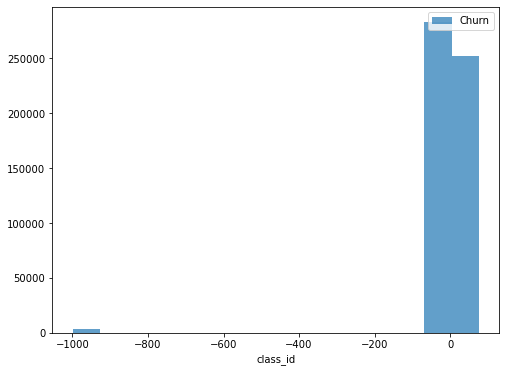

no churn:
count    134895.000000
mean          5.000371
std           0.134327
min           3.000000
5%            5.000000
25%           5.000000
50%           5.000000
75%           5.000000
90%           5.000000
95%           5.000000
99%           5.000000
max          29.000000
Name: class_id, dtype: float64


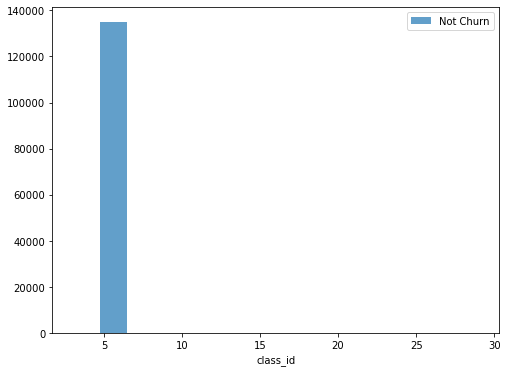

/Users/cherryyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------inception_date-----------
churn:
count    538444.000000
mean          0.809442
std           0.138693
min           0.000000
5%            0.524930
25%           0.806311
50%           0.808752
75%           0.889296
90%           0.954585
95%           0.978818
99%           0.996077
max           1.000000
Name: inception_date, dtype: float64


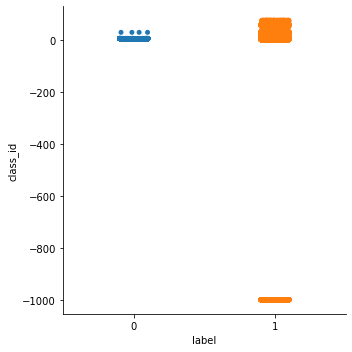

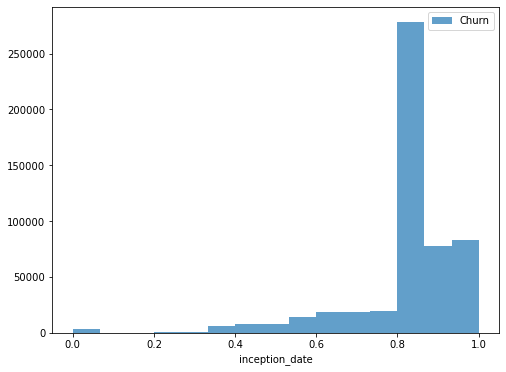

no churn:
count    134895.000000
mean          0.768119
std           0.117686
min           0.120206
5%            0.514993
25%           0.778679
50%           0.806311
75%           0.806311
90%           0.867329
95%           0.904899
99%           0.956154
max           0.998954
Name: inception_date, dtype: float64


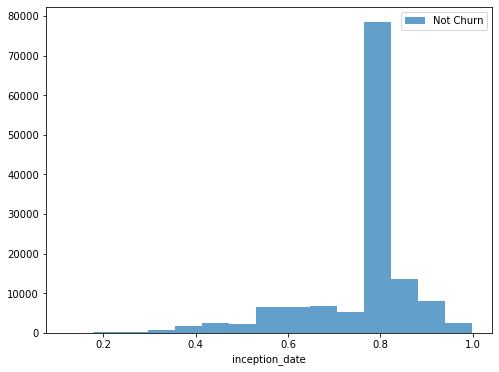

/Users/cherryyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------deceased_fair_market_value-----------
churn:
count    538444.00000
mean          0.53809
std          23.29564
min           0.00000
5%            0.00000
25%           0.00000
50%           0.00000
75%           0.00000
90%           0.00000
95%           0.00000
99%           0.00000
max        3493.74000
Name: deceased_fair_market_value, dtype: float64


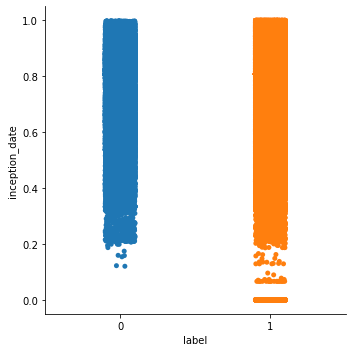

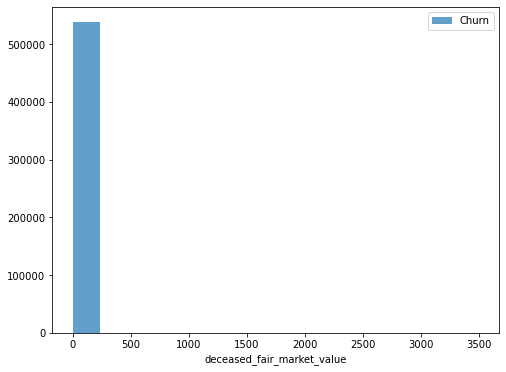

no churn:
count    134895.000000
mean          8.698001
std          92.143642
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%         316.830800
max        3481.280000
Name: deceased_fair_market_value, dtype: float64


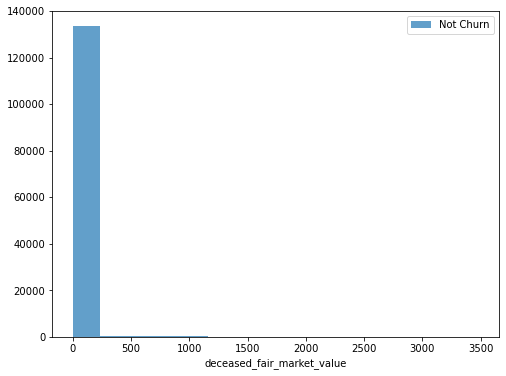

/Users/cherryyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


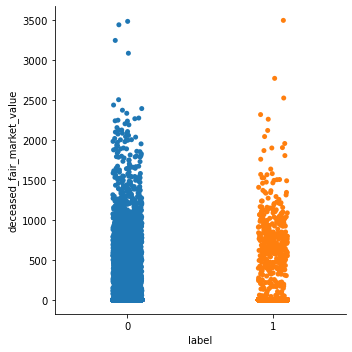

In [37]:
for col in numeric_variables_a:
    eda_func_num_a(col)

-----------last_update_date-----------
churn:
count    538444.000000
mean          0.644739
std           0.350955
min           0.000000
5%            0.000000
25%           0.466161
50%           0.786140
75%           0.913914
90%           0.963590
95%           0.981050
99%           0.996481
max           1.000000
Name: last_update_date, dtype: float64


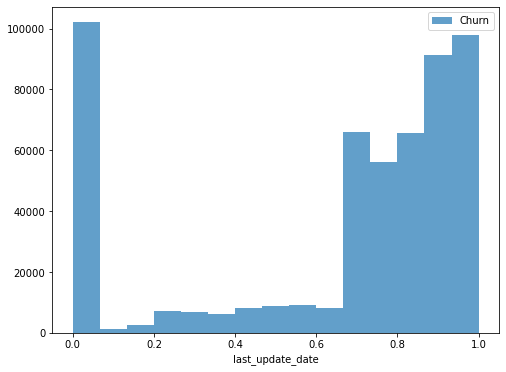

no churn:
count    134895.000000
mean          0.631880
std           0.242575
min           0.000000
5%            0.000000
25%           0.561722
50%           0.699648
75%           0.772604
90%           0.859773
95%           0.912019
99%           0.963048
max           0.999594
Name: last_update_date, dtype: float64


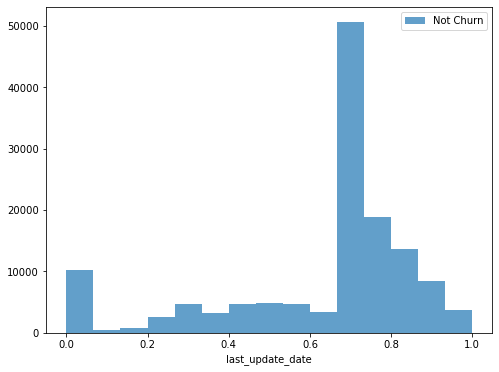

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------last_maintenance_time-----------
churn:
count    538444.000000
mean          0.809452
std           0.182324
min           0.000000
5%            0.422544
25%           0.726209
50%           0.849091
75%           0.940561
90%           0.977518
95%           0.989529
99%           0.997844
max           1.000000
Name: last_maintenance_time, dtype: float64


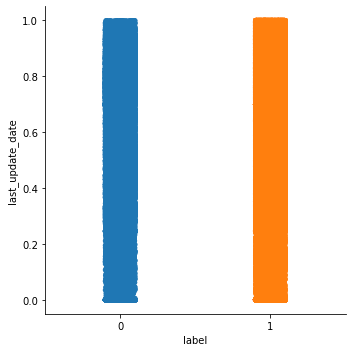

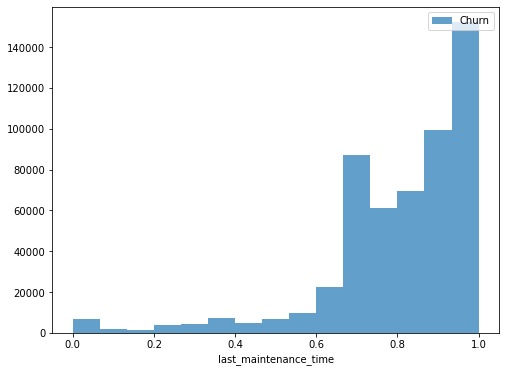

no churn:
count    134895.000000
mean          0.751309
std           0.196081
min           0.003080
5%            0.382507
25%           0.726209
50%           0.737296
75%           0.898676
90%           0.959963
95%           0.981213
99%           0.995996
max           1.000000
Name: last_maintenance_time, dtype: float64


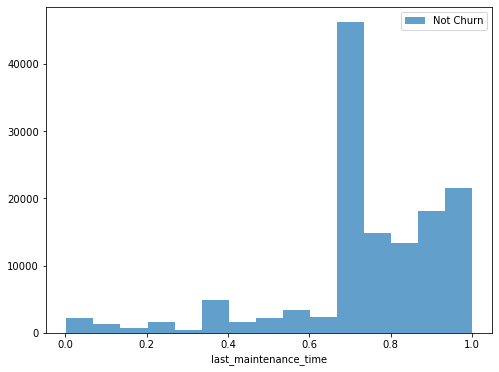

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------plan_effective_date-----------
churn:
count    538444.000000
mean          0.336512
std           0.409471
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.779847
90%           0.909343
95%           0.952541
99%           0.991677
max           1.000000
Name: plan_effective_date, dtype: float64


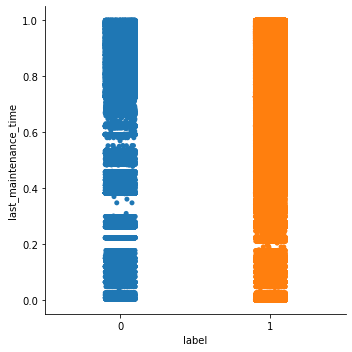

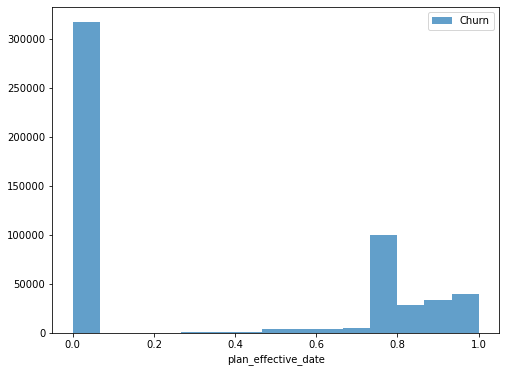

no churn:
count    134895.000000
mean          0.736323
std           0.134098
min           0.000000
5%            0.448727
25%           0.748390
50%           0.779847
75%           0.779847
90%           0.849103
95%           0.891905
99%           0.950163
max           0.998811
Name: plan_effective_date, dtype: float64


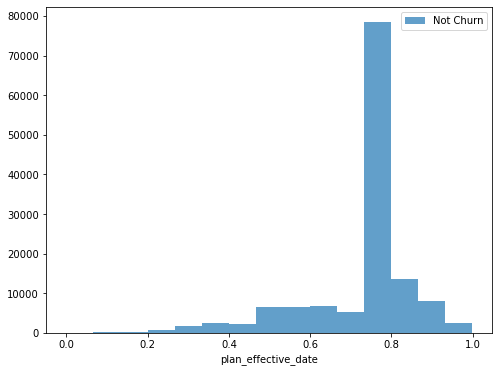

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------plan_end_date-----------
churn:
count    538444.000000
mean          0.029262
std           0.148246
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.860099
max           1.000000
Name: plan_end_date, dtype: float64


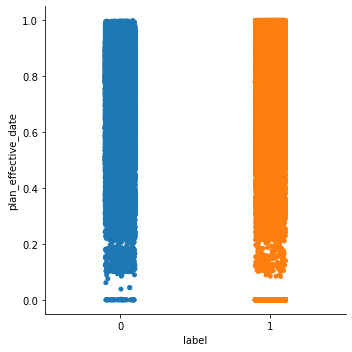

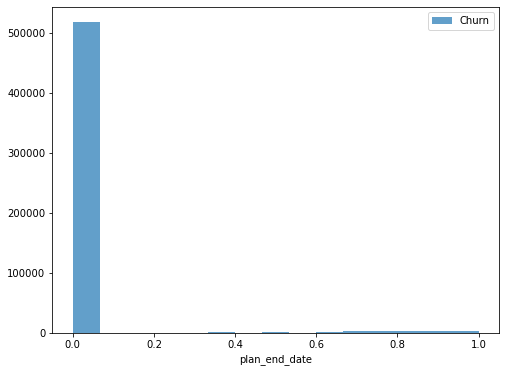

no churn:
count    134895.000000
mean          0.746443
std           0.168776
min           0.000000
5%            0.395033
25%           0.670364
50%           0.748675
75%           0.866722
90%           0.953642
95%           0.978146
99%           0.996854
max           1.000000
Name: plan_end_date, dtype: float64


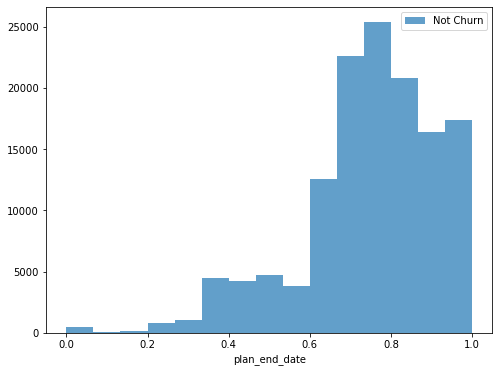

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------rrif_original_date-----------
churn:
count    538444.000000
mean          0.348901
std           0.423101
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.829024
90%           0.927901
95%           0.961911
99%           0.993229
max           1.000000
Name: rrif_original_date, dtype: float64


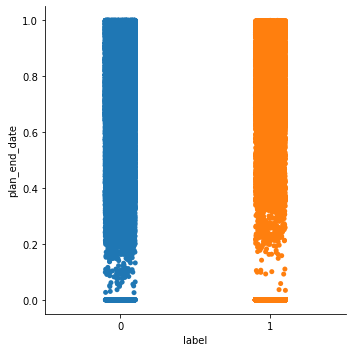

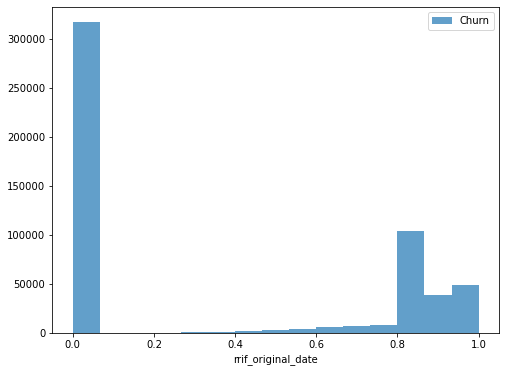

no churn:
count    134895.000000
mean          0.780709
std           0.124340
min           0.000000
5%            0.496999
25%           0.750693
50%           0.829024
75%           0.829024
90%           0.881656
95%           0.915436
99%           0.960680
max           0.999077
Name: rrif_original_date, dtype: float64


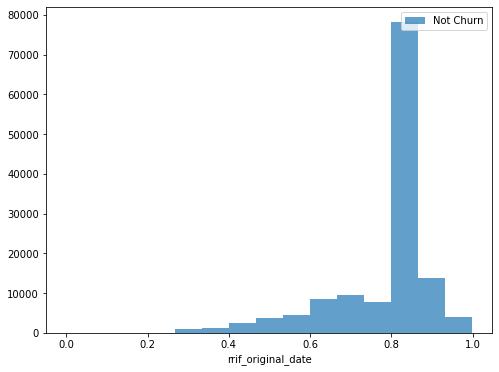

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------inserted_at-----------
churn:
count    538444.000000
mean          0.009609
std           0.079048
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.497206
max           1.000000
Name: inserted_at, dtype: float64


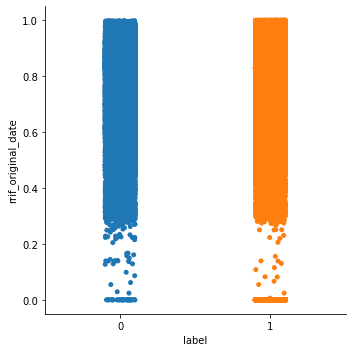

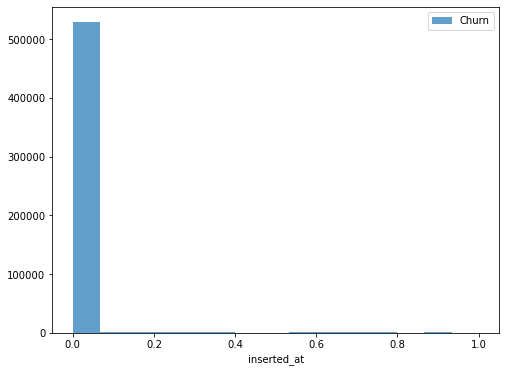

no churn:
count    134895.000000
mean          0.000197
std           0.010164
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.000000
max           0.856408
Name: inserted_at, dtype: float64


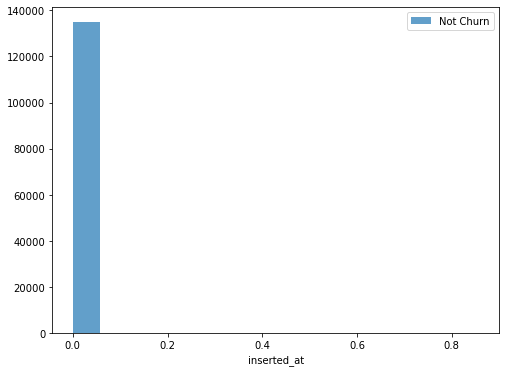

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------updated_at-----------
churn:
count    538444.000000
mean          0.842085
std           0.066762
min           0.000000
5%            0.835465
25%           0.835465
50%           0.835465
75%           0.860734
90%           0.860734
95%           0.861679
99%           0.912593
max           1.000000
Name: updated_at, dtype: float64


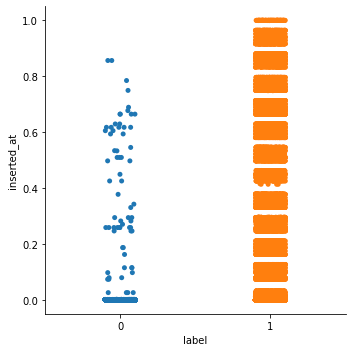

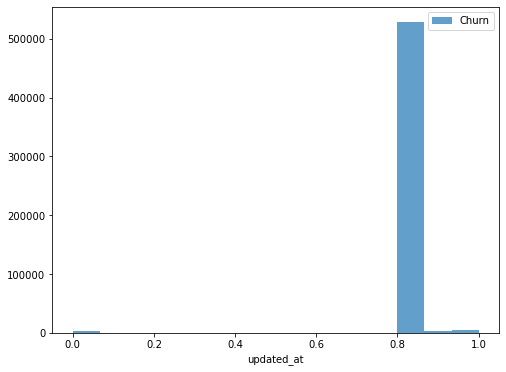

no churn:
count    134895.000000
mean          0.861467
std           0.008333
min           0.835465
5%            0.860734
25%           0.860734
50%           0.860734
75%           0.860734
90%           0.860734
95%           0.861663
99%           0.861746
max           1.000000
Name: updated_at, dtype: float64


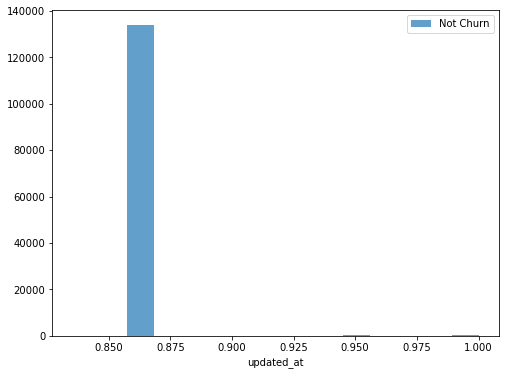

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------retail_last_maintenance_time-----------
churn:
count    538444.000000
mean          0.370335
std           0.447699
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.905727
90%           0.969101
95%           0.985633
99%           0.997441
max           1.000000
Name: retail_last_maintenance_time, dtype: float64


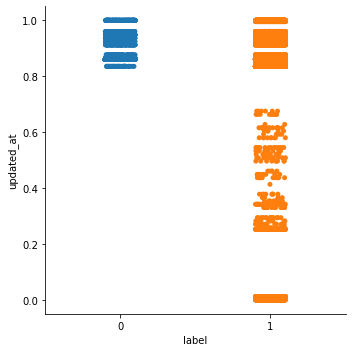

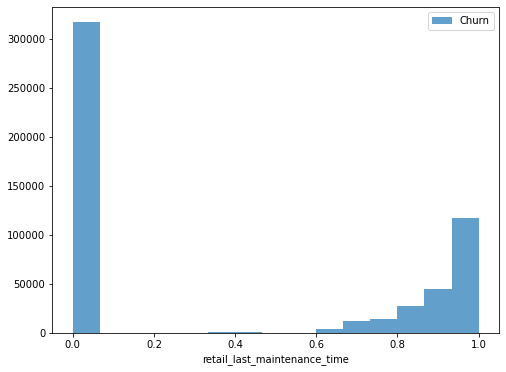

no churn:
count    134895.000000
mean          0.783667
std           0.172420
min           0.000000
5%            0.392639
25%           0.679197
50%           0.825034
75%           0.920685
90%           0.967329
95%           0.986223
99%           0.997441
max           1.000000
Name: retail_last_maintenance_time, dtype: float64


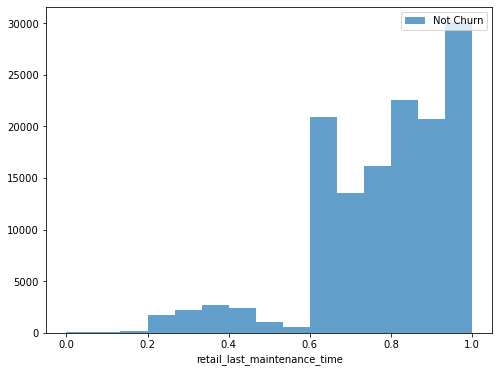

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------Low-----------
churn:
count    538444.000000
mean          7.575655
std          22.732897
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%          20.000000
95%          75.000000
99%          99.000000
max          99.000000
Name: Low, dtype: float64


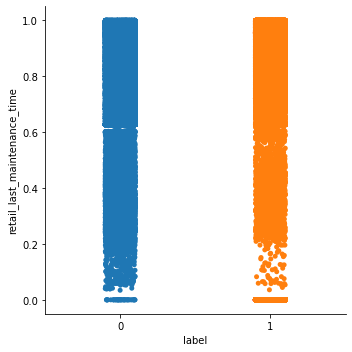

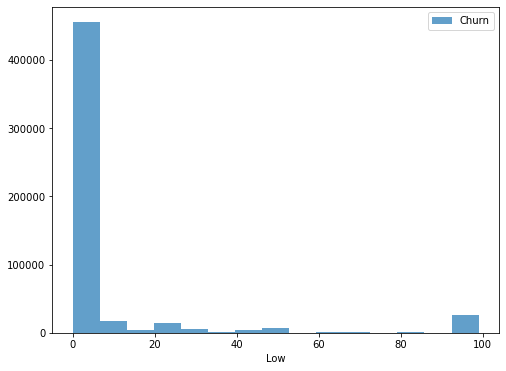

no churn:
count    134895.000000
mean          4.291286
std          14.885867
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%          10.000000
95%          25.000000
99%          99.000000
max          99.000000
Name: Low, dtype: float64


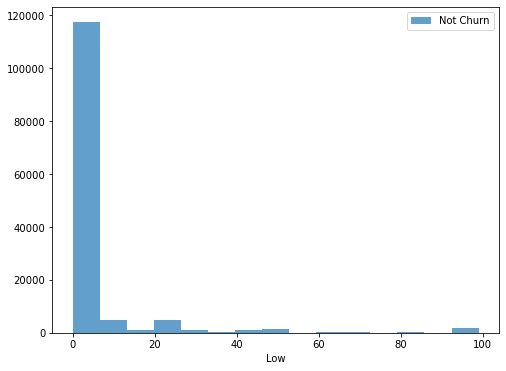

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------Medium-----------
churn:
count    538444.000000
mean         53.331349
std          41.216564
min           0.000000
5%            0.000000
25%           0.000000
50%          70.000000
75%          90.000000
90%          99.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: Medium, dtype: float64


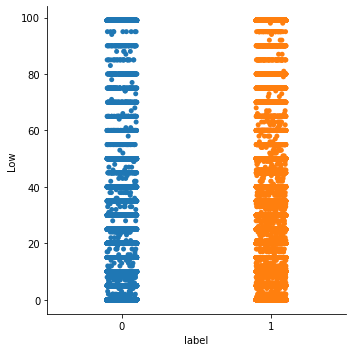

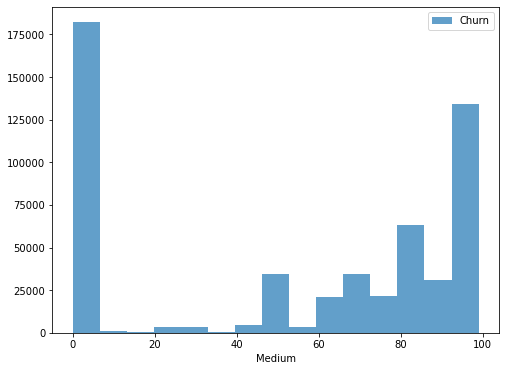

no churn:
count    134895.000000
mean         60.648920
std          38.560118
min           0.000000
5%            0.000000
25%          10.000000
50%          75.000000
75%          99.000000
90%          99.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: Medium, dtype: float64


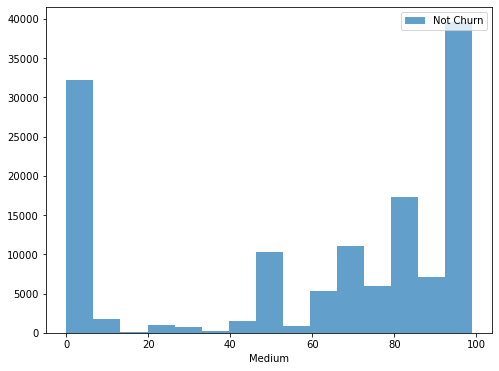

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------High-----------
churn:
count    538444.000000
mean         15.884203
std          26.480410
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          20.000000
90%          50.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: High, dtype: float64


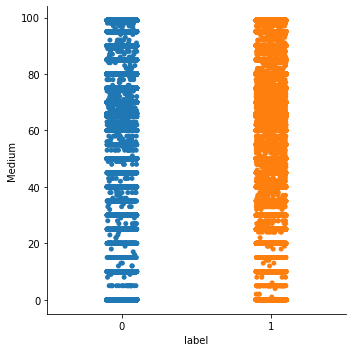

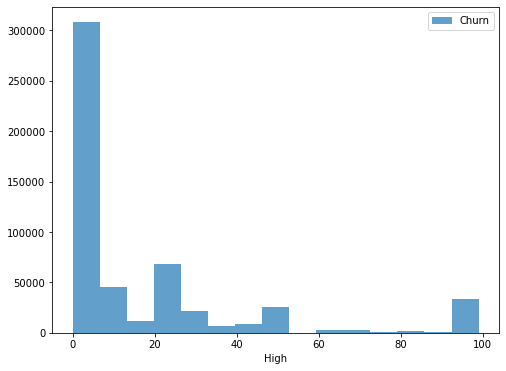

no churn:
count    134895.000000
mean         17.146047
std          25.826878
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          25.000000
90%          50.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: High, dtype: float64


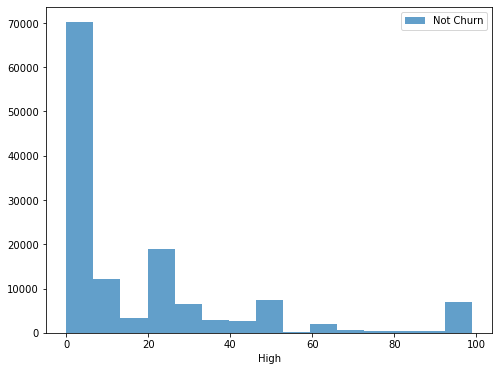

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------Income-----------
churn:
count    538444.000000
mean          8.933642
std          18.585673
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          10.000000
90%          35.000000
95%          50.000000
99%          99.000000
max          99.000000
Name: Income, dtype: float64


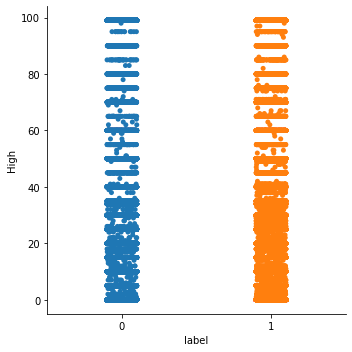

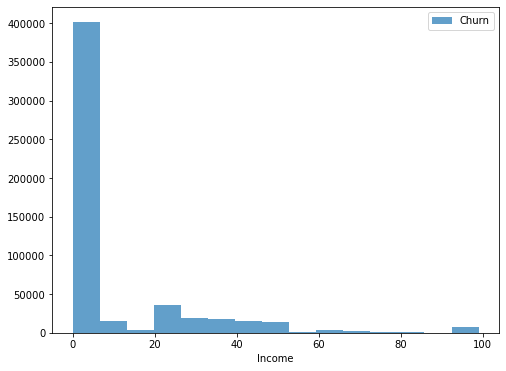

no churn:
count    134895.000000
mean          9.201720
std          18.341799
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          10.000000
90%          33.000000
95%          50.000000
99%          99.000000
max          99.000000
Name: Income, dtype: float64


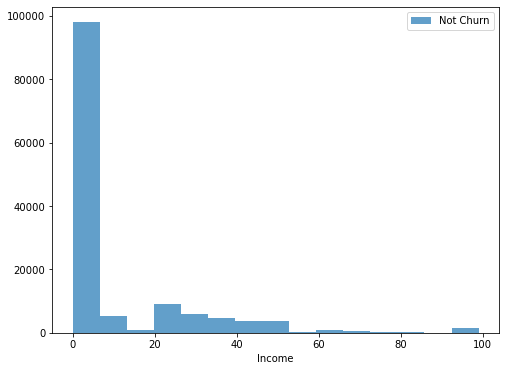

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------Growth-----------
churn:
count    538444.000000
mean         54.284791
std          41.397975
min           0.000000
5%            0.000000
25%           0.000000
50%          70.000000
75%          99.000000
90%          99.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: Growth, dtype: float64


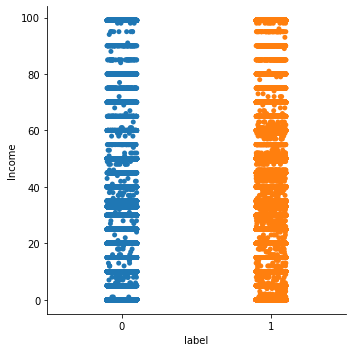

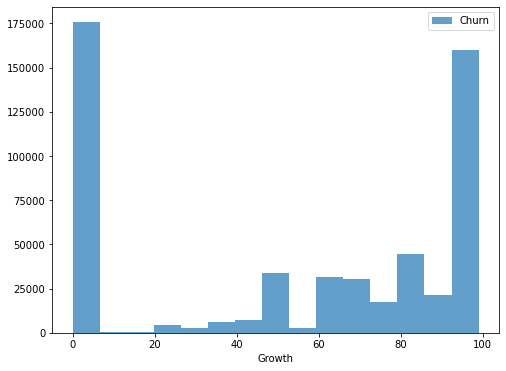

no churn:
count    134895.000000
mean         59.910820
std          38.826025
min           0.000000
5%            0.000000
25%          20.000000
50%          70.000000
75%          99.000000
90%          99.000000
95%          99.000000
99%          99.000000
max          99.000000
Name: Growth, dtype: float64


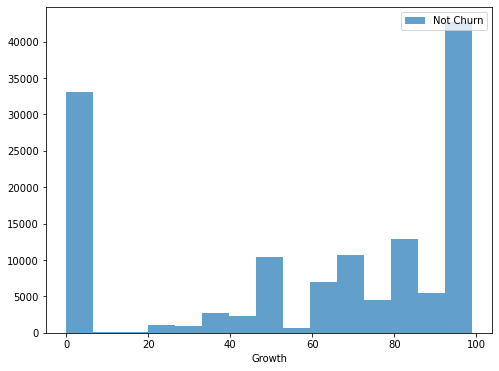

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------Speculative-----------
churn:
count    538444.000000
mean          9.649767
std          22.953030
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           5.000000
90%          30.000000
95%          50.000000
99%          99.000000
max         100.000000
Name: Speculative, dtype: float64


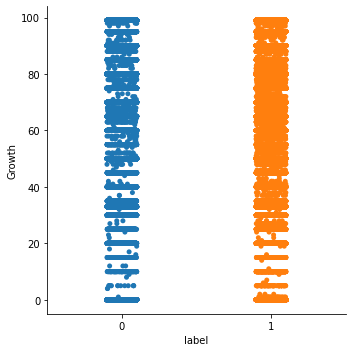

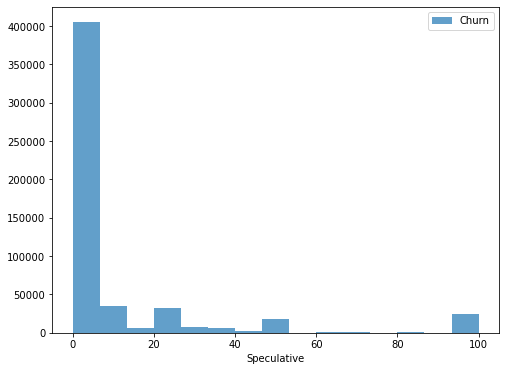

no churn:
count    134895.000000
mean         12.089381
std          23.422675
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%          15.000000
90%          50.000000
95%          50.000000
99%          99.000000
max          99.000000
Name: Speculative, dtype: float64


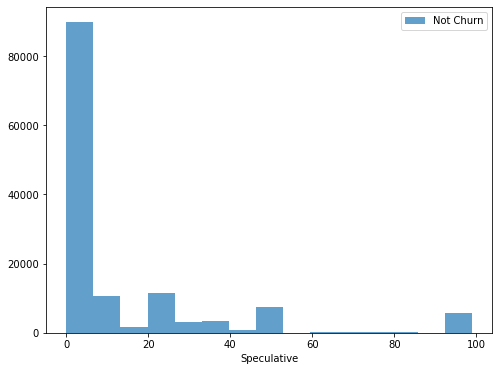

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------Medium-High-----------
churn:
count    538444.0
mean          0.0
std           0.0
min           0.0
5%            0.0
25%           0.0
50%           0.0
75%           0.0
90%           0.0
95%           0.0
99%           0.0
max           0.0
Name: Medium-High, dtype: float64


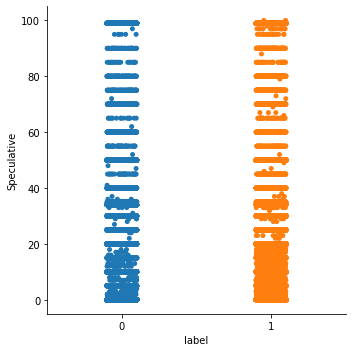

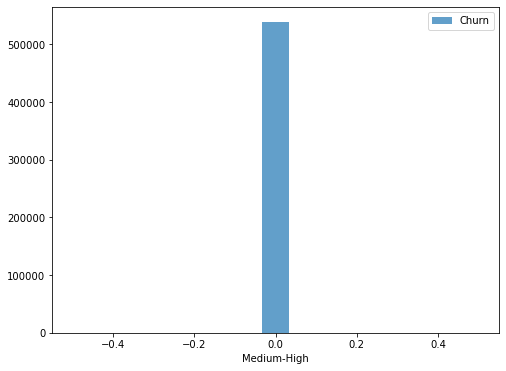

no churn:
count    134895.0
mean          0.0
std           0.0
min           0.0
5%            0.0
25%           0.0
50%           0.0
75%           0.0
90%           0.0
95%           0.0
99%           0.0
max           0.0
Name: Medium-High, dtype: float64


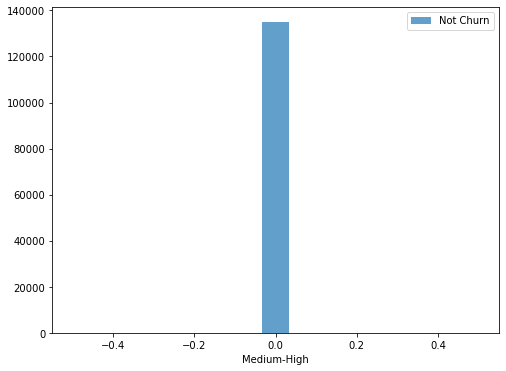

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------Liquidity-----------
churn:
count    538444.000000
mean          3.910639
std          18.869474
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           5.000000
99%          99.000000
max          99.000000
Name: Liquidity, dtype: float64


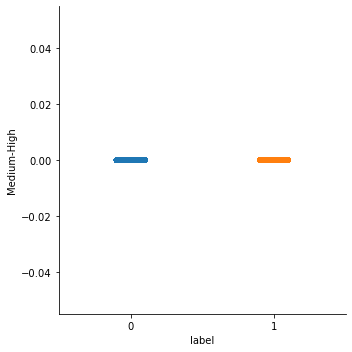

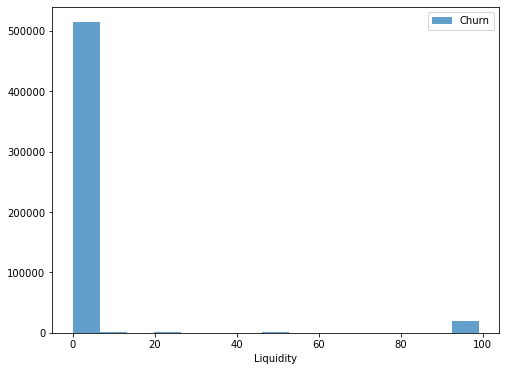

no churn:
count    134895.000000
mean          1.313577
std           8.750313
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%          50.000000
max          99.000000
Name: Liquidity, dtype: float64


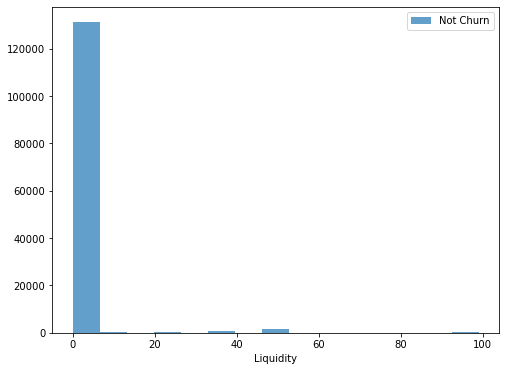

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-----------Safety-----------
churn:
count    538444.000000
mean          0.004764
std           0.535307
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.000000
max          99.000000
Name: Safety, dtype: float64


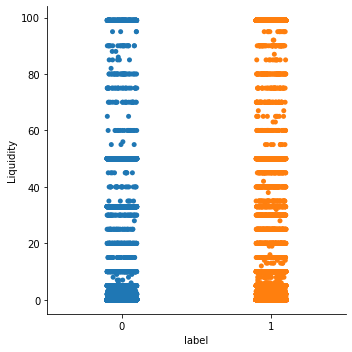

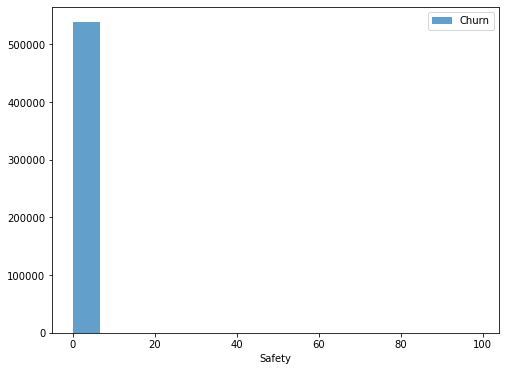

no churn:
count    134895.000000
mean          0.008028
std           0.782272
min           0.000000
5%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
95%           0.000000
99%           0.000000
max          99.000000
Name: Safety, dtype: float64


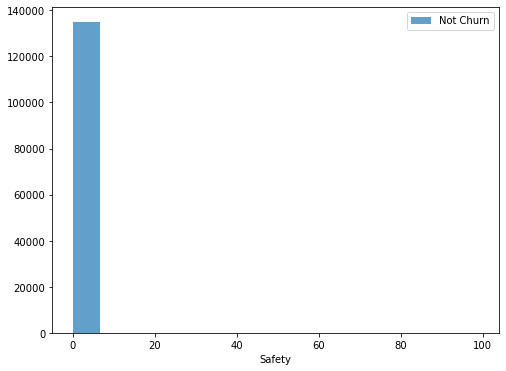

/Users/cloriszhang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


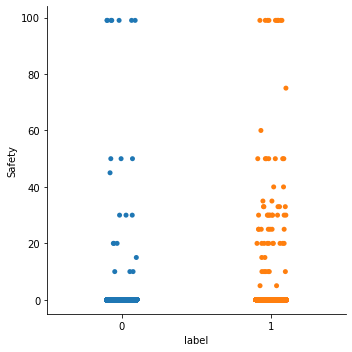

In [ ]:
for col in numeric_variables_ba:
    eda_func_num_ba(col)